<a href="https://colab.research.google.com/github/Samuelameningayeh/malaria-detection-cnn/blob/main/Malaria_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING LIBRARIES AND SETUP

In [1]:
# %pip install torch torchvision matplotlib pandas
# %pip install tqdm

In [2]:
## clone the Repo
import os
from google.colab import files

if not os.path.exists('malaria-detection-cnn'):
    print("Cloning your repository...")
    !git clone https://github.com/Samuelameningayeh/malaria-detection-cnn.git
    %cd malaria-detection-cnn
else:
    print("Repo already exists. Entering folder...")
    %cd malaria-detection-cnn
    !git pull # Ensure we have the latest fixes


Repo already exists. Entering folder...
/content/malaria-detection-cnn
Already up to date.


In [3]:
# --- PART 2: UPLOAD KAGGLE KEY ---
print("\n👇 CLICK THE BUTTON BELOW TO UPLOAD 'kaggle.json' 👇")
uploaded = files.upload() # <--- Select the file you just downloaded

# Move the key to the correct spot
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Kaggle Key Configured!")

# --- PART 3: DOWNLOAD DATA ---
if not os.path.exists('cell_images'):
    print("\nDownloading Dataset (This is fast)...")
    !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

    print("Unzipping...")
    !unzip -q cell-images-for-detecting-malaria.zip

    # Fix Kaggle's weird folder nesting
    if os.path.exists('cell_images/cell_images'):
        !mv cell_images/cell_images cell_images_fixed
        !rm -rf cell_images
        !mv cell_images_fixed cell_images

    print("✅ Data Ready: 'cell_images' folder created.")
else:
    print("✅ Data already exists.")


👇 CLICK THE BUTTON BELOW TO UPLOAD 'kaggle.json' 👇


Saving kaggle.json to kaggle (1).json
✅ Kaggle Key Configured!
✅ Data already exists.


In [4]:
# Auto-reload modules so we don't have to restart the kernel if we change code
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from time import time

# Import your custom modules
from model import MalariaCNN
from dataloading import create_dataloaders
from train import train_step
from evaluation import evaluate_step
from plotting import plot_sample_images, plot_results, plot_predictions

# Config
DATA_PATH = 'cell_images'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

Running on: cuda


# LOADING DATASET

Classes found: ['Parasitized', 'Uninfected']
Training Batches: 603 | Validation Batches: 173 | Test Batches: 87

 Sample Microscopic Images (Normalized):


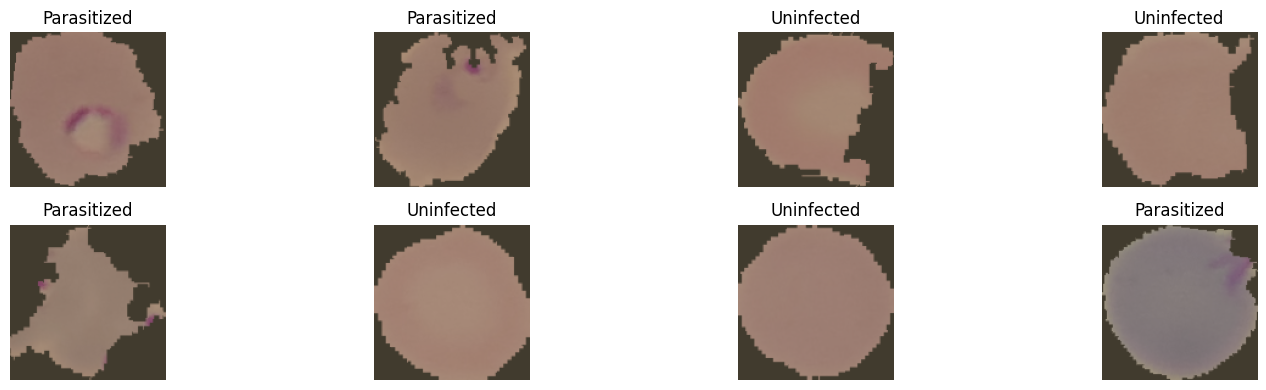

In [5]:
# 1. Initialize Loaders
train_loader, val_loader, test_loader, class_names = create_dataloaders(DATA_PATH, batch_size=32)

print(f"Classes found: {class_names}")
print(f"Training Batches: {len(train_loader)} | Validation Batches: {len(val_loader)} | Test Batches: {len(test_loader)}")

# 2. Visual Inspection (EDA)
print("\n Sample Microscopic Images (Normalized):")
plot_sample_images(train_loader, class_names)

# MODEL PREPARATION AND TRAINING

## 1 . Loading the Model

In [6]:
model = MalariaCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Model Architecture:")
print(model)

Model Architecture:
MalariaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


## 2 . Training the Model

In [7]:
EPOCHS = 10
results = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print(f"Starting training for {EPOCHS} epochs...")
start_time = time()

for epoch in range(EPOCHS):
    # 1. Train
    t_loss, t_acc = train_step(model, train_loader, criterion, optimizer, DEVICE)

    # 2. Evaluate
    v_loss, v_acc = evaluate_step(model, val_loader, criterion, DEVICE)

    # 3. Log
    results['train_loss'].append(t_loss)
    results['train_acc'].append(t_acc)
    results['val_loss'].append(v_loss)
    results['val_acc'].append(v_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Acc: {t_acc:.2f} | Val Acc: {v_acc:.2f} | Train Loss: {t_loss:.3f} | Val Loss: {v_loss:.3f}")

total_time = time() - start_time
print(f"\nTraining Complete in {total_time/60:.2f} minutes.")

Starting training for 10 epochs...


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1/10] | Train Acc: 0.90% | Val Acc: 0.94% | Train Loss: 0.240 | Val Loss: 0.166


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2/10] | Train Acc: 0.96% | Val Acc: 0.95% | Train Loss: 0.144 | Val Loss: 0.147


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3/10] | Train Acc: 0.96% | Val Acc: 0.96% | Train Loss: 0.134 | Val Loss: 0.133


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4/10] | Train Acc: 0.96% | Val Acc: 0.96% | Train Loss: 0.130 | Val Loss: 0.128


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5/10] | Train Acc: 0.96% | Val Acc: 0.95% | Train Loss: 0.128 | Val Loss: 0.127


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6/10] | Train Acc: 0.96% | Val Acc: 0.96% | Train Loss: 0.122 | Val Loss: 0.116


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7/10] | Train Acc: 0.96% | Val Acc: 0.96% | Train Loss: 0.119 | Val Loss: 0.119


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8/10] | Train Acc: 0.96% | Val Acc: 0.96% | Train Loss: 0.119 | Val Loss: 0.121


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9/10] | Train Acc: 0.96% | Val Acc: 0.96% | Train Loss: 0.115 | Val Loss: 0.120


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validating:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10/10] | Train Acc: 0.96% | Val Acc: 0.95% | Train Loss: 0.115 | Val Loss: 0.133

Training Complete in 9.33 minutes.


# MODEL EVALUATION

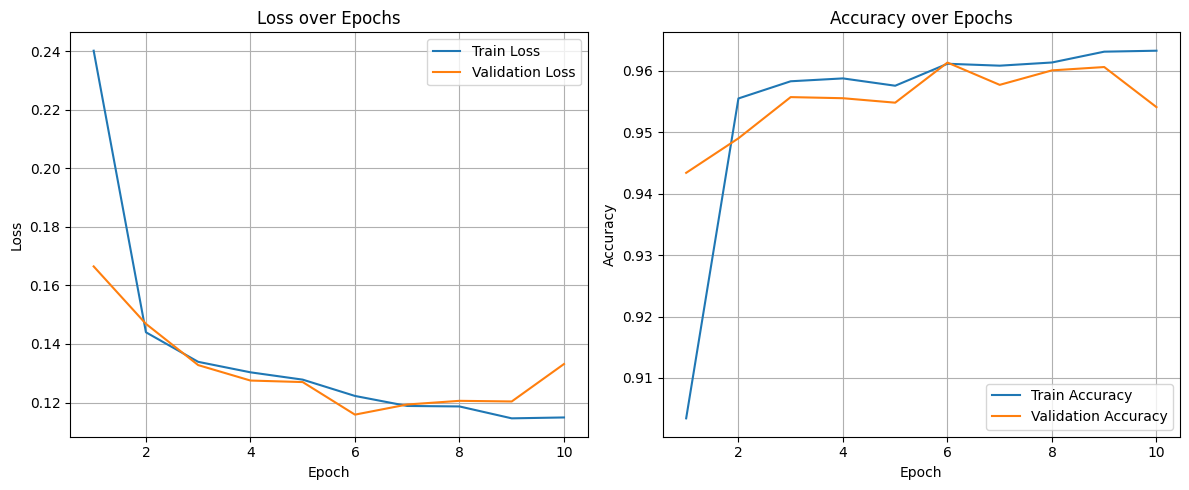

In [8]:
# Visualize Performance
plot_results(results, save=True)

# Save Model
# torch.save(model.state_dict(), 'malaria_cnn_v1.pth')
# print("Model saved to disk.")

# INFERENCE

In [9]:
# Save the trained model for future use
torch.save(model.state_dict(), 'malaria_cnn_final.pth')
print("\nModel saved to disk.")


Model saved to disk.


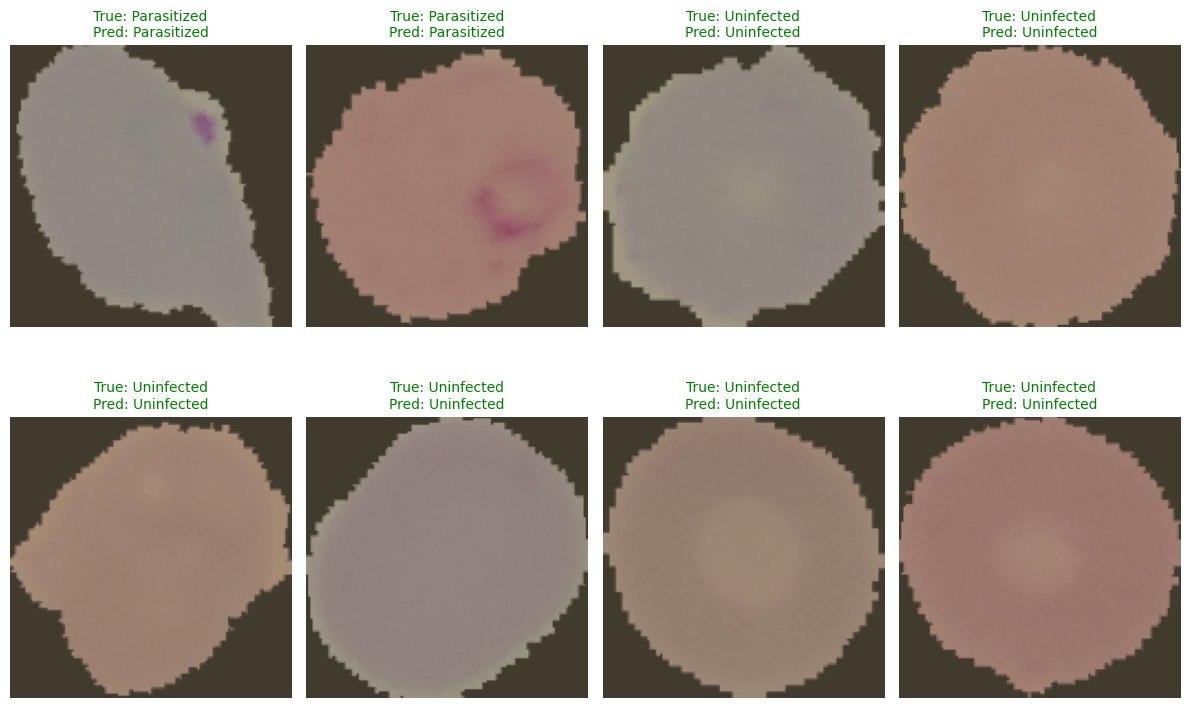

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('malaria_cnn_final.pth'))

# get a batch and predict on it
plot_predictions(model,test_loader,class_names, DEVICE, save=True)